# Advanced Machine Learning Final Project - Travel Habits
## **Supervised Learning**
* Eylon Yehiel
* Michael Mutter

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
from datetime import timedelta

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree

from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

import warnings

C:\Users\elon2\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
warnings.filterwarnings('ignore')

In [4]:
p1 = os.getcwd()+'\\TH-data\\aas_1.csv'
p2 = os.getcwd()+'\\TH-data\\hhs_1.csv'
p3 = os.getcwd()+'\\TH-data\\pps_1.csv'
# Activities, Vechiles, households and people.
aas, hhs, pps = (pd.read_csv(file) for file in [p1, p2, p3])

In [5]:
print('Activities:\n', aas.columns, '\n===============================================================================')
print('HouseHolds:\n', hhs.columns, '\n===============================================================================')
print('Individuals:\n', pps.columns, '\n===============================================================================')

Activities:
 Index(['survey3', 'HHID3', 'IndID3', 'SurveyDay', 'placeno', 'mainActivity',
       'mainmode', 'numAccomp', 'arrtime', 'deptime', 'parkType', 'wf3',
       'TypNdx', 'STStr', 'STArr', 'STDep', 'TrvlTime', 'TrvlDist', 'StayTime',
       'actGizra', 'actSemel', 'actTaz', 'locType', 'PerID3', 'tfrs', 'legs',
       'Times', 'Dists', 'version'],
      dtype='object') 
HouseHolds:
 Index(['survey1', 'survey_num', 'hhid', 'sector', 'hhsize', 'HHChild8',
       'hhveh', 'hhmicroveh', 'days', 'day1', 'day2', 'wf1', 'hhSemel',
       'Yshuvtype', 'Mahoz', 'Gizra', 'hhtaz', 'Mosad', 'HHType', 'HHMembers',
       'year', 'version'],
      dtype='object') 
Individuals:
 Index(['survey2', 'hhid2', 'indID', 'relat', 'gender', 'age', 'degree',
       'study', 'EmpStat', 'workparking', 'clic', 'mlic', 'device', 'days2',
       'acts1', 'acts2', 'wf2', 'PerID', 'version'],
      dtype='object') 


#### Activities data

In [7]:
aas.head(3)

,survey3,HHID3,IndID3,SurveyDay,placeno,mainActivity,mainmode,numAccomp,arrtime,deptime,...,actGizra,actSemel,actTaz,locType,PerID3,tfrs,legs,Times,Dists,version
0,bsh,1000060,1,1,1,1,0,1.0,19/02/2014 3:00:00,19/02/2014 11:48:45,...,310.0,9000.0,2382.0,1,4-1000060-1,NaN,NaN,NaN,NaN,1
1,bsh,1000060,1,1,2,5,1,1.0,19/02/2014 11:57:35,19/02/2014 12:23:59,...,310.0,9000.0,2382.0,1,4-1000060-1,NaN,NaN,NaN,NaN,1
2,bsh,1000060,1,1,3,5,1,1.0,19/02/2014 12:33:59,19/02/2014 13:36:00,...,310.0,9000.0,2382.0,1,4-1000060-1,NaN,NaN,NaN,NaN,1


In [8]:
# Making sure that residuals wont' not remain and turn into NaN.
set(aas['PerID3']) == set(pps['PerID']) and set(hhs['hhid']) == set(aas['HHID3'])

True

---

#### Data prepararion:

In [11]:
aas.rename(columns = {'HHID3':'hhid','PerID3':'PerID'}, inplace = True)
# Merge data sets for features to make informative models
df = aas.merge(hhs, how = 'left', on = 'hhid').merge(pps, how = 'left', on = 'PerID')

In [12]:
df = df[df.TrvlDist.notnull() & df['mainActivity'] != 1] # Staying at home is not actual activity

In [13]:
# DateTime casting and extracting relevent info
df['arrtime'] = pd.to_datetime(df['arrtime'], format="%d/%m/%Y %H:%M:%S", errors='coerce')
df['deptime'] = pd.to_datetime(df['arrtime'], format="%d/%m/%Y %H:%M:%S", errors='coerce')
df['year'] = df['arrtime'].dt.year
df['month'] = df['arrtime'].dt.month
df['day_atin_week'] = df['arrtime'].dt.dayofweek  # Monday = 0, Sunday = 6
df = df.drop(columns = ['arrtime', 'deptime','tfrs','IndID3', 'indID', 'hhid','hhid2','actGizra', 'actSemel','actTaz'])

#### Feature selection

##### Keep only enrties of travels - remove first activities and data of staying at home (travel distance = 0)
* mainmode can not be first activity (0), 'other' (13) or 'unkmown' (99)

In [16]:
target = 'mainmode'
df = df[df.select_dtypes(exclude='object').columns]
df = df[(df.mainmode != 0) & (df.mainmode != 13) & (df.mainmode != 99)]
df = df[df.mainActivity != 1]

X = df.drop(target, axis=1)
y = df[target]

##### Using Decision-tree to get a clue about feature importances

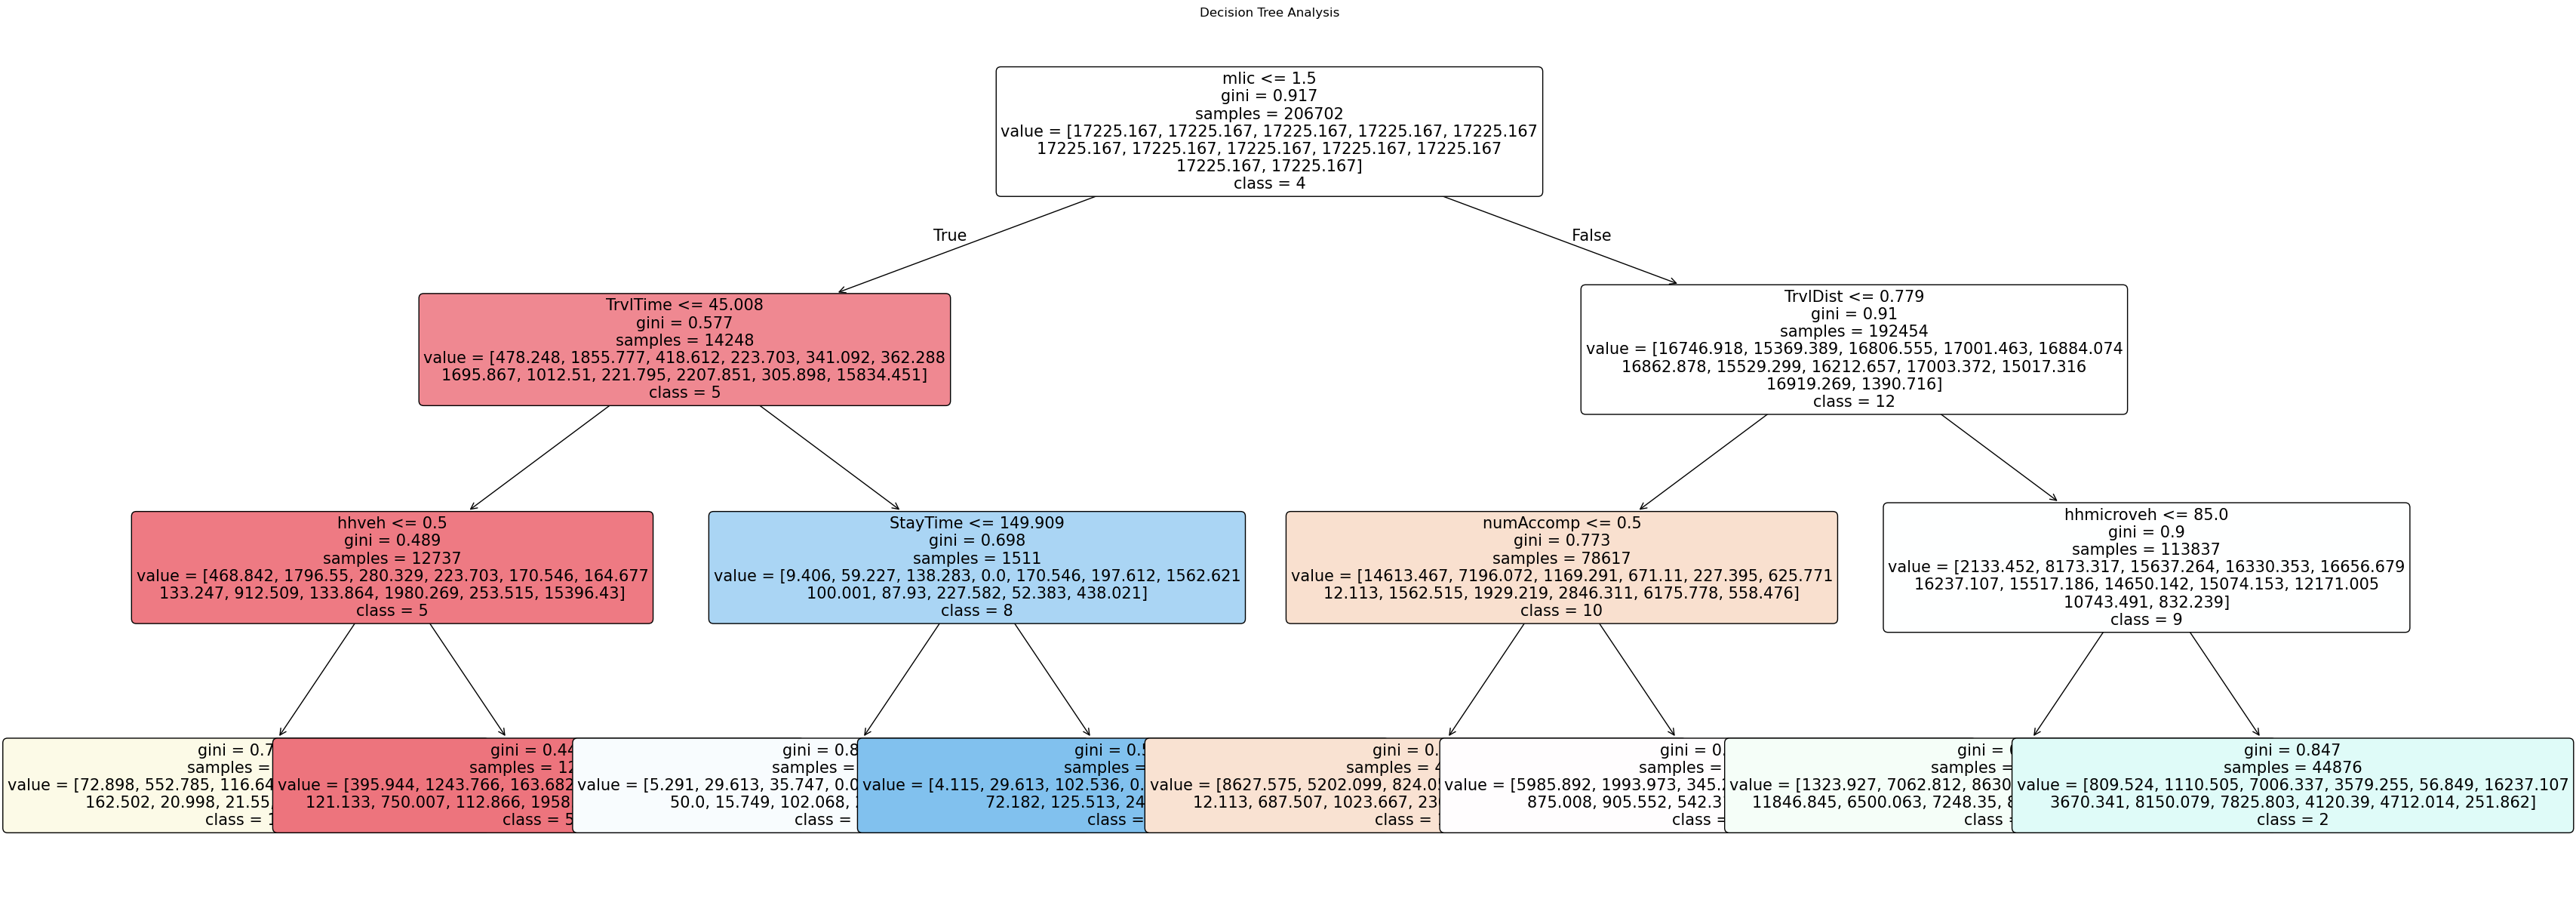

In [18]:
feature_names = X.columns 
target_names = [str(cls) for cls in y.unique()]

tree = DecisionTreeClassifier(random_state=42, max_depth = 3, class_weight = 'balanced')
tree.fit(X, y)

def plot_decision_tree(tree, feature_names, target_names, title="Decision Tree Analysis"):
    plt.figure(figsize=(40, 15))
    plot_tree(tree, feature_names=feature_names, class_names=target_names,filled=True, rounded=True, fontsize=15)
    plt.title(title)
    plt.show()
plot_decision_tree(tree, feature_names, target_names, title="Decision Tree Analysis")

In [19]:
def analyze_feature_importance(tree, feature_names):
    importances = dict(zip(feature_names, tree.feature_importances_))
    importances = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))
    importances = pd.DataFrame(importances, index=['Importance']).T
    return importances

In [20]:
importances = analyze_feature_importance(tree, feature_names)
importances[:5]

,Importance
mlic,0.390861
TrvlDist,0.266112
hhmicroveh,0.196905
TrvlTime,0.062896
numAccomp,0.059553


---

#### Stratification Check

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

* 80% train
* 20% test

##### Making sure target is stratified

In [26]:
pd.DataFrame({'Test-Train ratio':[i for i in y_test.value_counts().values/y_train.value_counts().values]},
              index = y_train.value_counts().index)

,Test-Train ratio
mainmode,
10,0.249996
1,0.250000
11,0.249991
3,0.249983
9,0.250000
2,0.250000
12,0.250397
7,0.249561
8,0.250454


# Supervised Learning

## Models Comparison

In [29]:
aas.rename(columns = {'HHID3':'hhid','PerID3':'PerID'}, inplace = True)
df = aas.merge(hhs, how = 'left', on = 'hhid').merge(pps, how = 'left', on = 'PerID')
cdf = df.copy()

In [30]:
cat_feats = ['mainmode','mainActivity','TypNdx', 'gender', 'locType','sector','Yshuvtype','Mahoz','study', 'EmpStat', 'degree','clic'] 
num_feats = ['STStr','STArr','STDep','TrvlDist','TrvlTime','StayTime','hhsize','HHChild8','hhveh','age','year', 'acts1', 'numAccomp']
labels = ["walk", "bicycle", "bus", "service taxi", "metro", "light rail", "train", "taxi", "shuttle", "driver", "passenger", "motorcycle/scooter"]
target = cat_feats[0] # Main Mode

# Define X and y also outside the function to enable necessary approach
X = df.drop(target, axis=1)
y = df[target]

#### Functions definition

In [32]:
def preprocess_data(df):
    '''
    Cleaning function to enable the data be model's input
    '''
    tdf = df[cat_feats + num_feats]
    tdf = tdf[tdf.TrvlDist.notnull()]
    tdf = tdf[(tdf.mainmode != 0) & (tdf.mainmode != 13) & (tdf.mainmode != 99)] # Removing unknown targets (99), 'other' answers (13) and first activities (0)
    tdf = tdf[tdf.mainActivity != 1]
    y = tdf['mainmode']      # target extraction
    X = tdf.drop(columns=['mainmode'])

    # Categorize target and categorical features 
    for col in cat_feats[1:]:
        X[col] = X[col].astype('category')
    y = y.astype('category')
    
    return X, y

In [33]:
def extract_from_report(report):
    '''
    extracts precisoin, recall and F1 score from classification report outputed as a dictionary
    '''
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    print(f"precision: {precision:.3f}\nrecall: {recall:.3f}\nF1 score: {f1:.3f}")

In [34]:
def nn_preprocessor():
    '''
    returns initialized train-test partition for neural network
    '''
    df = aas.merge(hhs, how = 'left', on = 'hhid').merge(pps, how = 'left', on = 'PerID') # initialize dataset for clean results
    
    nn_preprocessor = end2end_pipeline(df, num_feats, cat_feats[1:], nn_model, nn = True, zero_labeling = True) # using our pipeline to get NN preprocessor
    X, y = preprocess_data(df)
    y = to_categorical(y)
    y = y[:,1:]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
    X_train = nn_preprocessor.fit_transform(X_train)
    X_test = nn_preprocessor.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [35]:
def nn_creator():
    '''
    creates neural network in the following configuration, compiles it and defines callbacks
    '''
    model = Sequential([
        Dense(units=256, activation='relu'),
        BatchNormalization(),
        Dense(units=128, activation='relu'),
        BatchNormalization(),
        Dense(units=64, activation='relu'),
        BatchNormalization(),
        Dense(12, activation='softmax')
        ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [36]:
def plot_history(history):
    '''
    plot thr trainig process given `history` of train along the epochs 
    '''
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

In [37]:
def nn_iteration(model, n_epoch = 30, batch_size = 100):
    '''
    One round of model fitting due to given arguments. 
    plots the training process and extracts best weights
    '''
    X_train, X_test, y_train, y_test = nn_preprocessor()

    early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
    check_point = ModelCheckpoint(filepath= "NN.keras", save_best_only=True, monitor="val_loss")
    history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=batch_size,
                        validation_split = 0.2,
                        callbacks=[early_stopping, check_point],
                        verbose=1)
    plot_history(history)

    best_model = load_model("NN.keras")
    print(f"Best model evaluation: {best_model.evaluate(X_test, y_test)}")

    y_pred = best_model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    clf_report = classification_report(y_test, y_pred, output_dict=False)
    print(f"\nClassification report:\n {clf_report}")

    clf_report = classification_report(y_test, y_pred, output_dict=True)
    extract_from_report(clf_report)

    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', display_labels=labels)
    plt.title("Confusion Matrix")  
    plt.gcf().set_size_inches(12, 8)
    plt.show

    normalized_cm(y_test, y_pred)
    
    return best_model

In [38]:
def normalized_cm(y_test, y_pred, axis = 0):
    '''
    Generate normalized confusion matrix.
    Attribute `axis` determines if the normalization done on the rows(0) or on columns (1)
    The meaning is Recall/Precision indicies
    '''
    cm = confusion_matrix(y_test, y_pred)
    row_sums = cm.sum(axis=axis, keepdims=True) # Change 1/0 to examine recall vs precision
    normalized_matrix = cm / row_sums
    normalized_matrix = normalized_matrix.round(2)
    # Visualize normalized matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=normalized_matrix, display_labels=labels)
    disp.plot(cmap="Blues", ax=ax, colorbar=True)
    plt.xticks(rotation=45)
    plt.title("Normalized Confusion Matrix (Proportions)")
    plt.show()

In [39]:
def end2end_pipeline(df, numerical_features ,categorical_features ,model, abort_scaling = False, zero_labeling = False, nn = False, abort_X_oh = False):
    '''
    End to end pipeline for preprocessing, feature engineering, model selection, training, evaluation, and interpretation
    '''
    categorical_features = categorical_features[1:]   
    
    if abort_scaling:
        numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
        ])
    else:
        numerical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', MinMaxScaler())
        ])
    
    if abort_X_oh:
        categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
        ])
    else: 
        categorical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')), 
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first', sparse_output = False))  
        ])

    
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

    if nn:
        return preprocessor
    else:
        model_pipeline = Pipeline([
            ('preprocessor', preprocessor), 
            ('classifier', model) 
        ])

    X, y = preprocess_data(df)
    
    if zero_labeling:
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
    
    model_pipeline.fit(X_train, y_train)
        
    score = model_pipeline.score(X_test, y_test)
    print(f"Model accuracy: {score:.3f}")

    y_pred = model_pipeline.predict(X_test)
    clf_report = classification_report(y_test, y_pred, target_names = labels, output_dict=False)
    print(f"\nClassification report:\n {clf_report}")

    clf_report = classification_report(y_test, y_pred, output_dict=True)
    extract_from_report(clf_report)

    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues')
    plt.title("Confusion Matrix")  
    plt.gcf().set_size_inches(12, 8)
    plt.show()
    normalized_cm(y_test, y_pred)
        
    return model_pipeline

In [40]:
# Initialize chosen algorithms

rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
xgb_model = XGBClassifier(objective="multi:softmax", num_class=np.unique(y).size, n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=np.unique(y).size, n_estimators=200, learning_rate=0.1, n_jobs=-1)
cat_model = CatBoostClassifier(iterations=200, learning_rate=0.1, loss_function='MultiClass', eval_metric='MultiClass')
nn_model = nn_creator()
lr_model = LogisticRegression(penalty = 'l2', max_iter=1000, multi_class = 'multinomial', n_jobs=-1, warm_start = True)

In [41]:
models = {'Random Forest': rf_model,
          'XGBoost': xgb_model,
          'LightGBM': lgb_model,
          'CatBoost': cat_model,
          'Logistic Regression': lr_model,
          'Neural Network': nn_model}

Random Forest model:
Model accuracy: 0.838

Classification report:
                     precision    recall  f1-score   support

              walk       0.85      0.87      0.86     21099
           bicycle       0.87      0.21      0.34      1171
               bus       0.71      0.64      0.68      5735
      service taxi       0.86      0.09      0.17       131
             metro       1.00      0.18      0.30        85
        light rail       1.00      0.02      0.03       196
             train       0.80      0.17      0.28       448
              taxi       0.97      0.11      0.19       538
           shuttle       0.87      0.64      0.74      3064
            driver       0.84      0.95      0.89     36158
         passenger       0.86      0.78      0.82     15575
motorcycle/scooter       1.00      0.15      0.26       652

          accuracy                           0.84     84852
         macro avg       0.89      0.40      0.46     84852
      weighted avg       0.84 

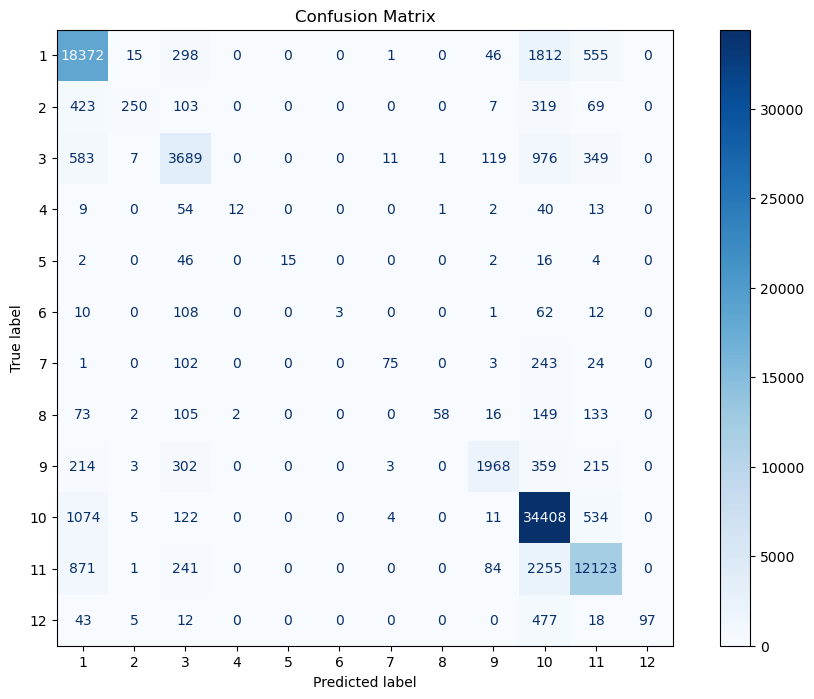

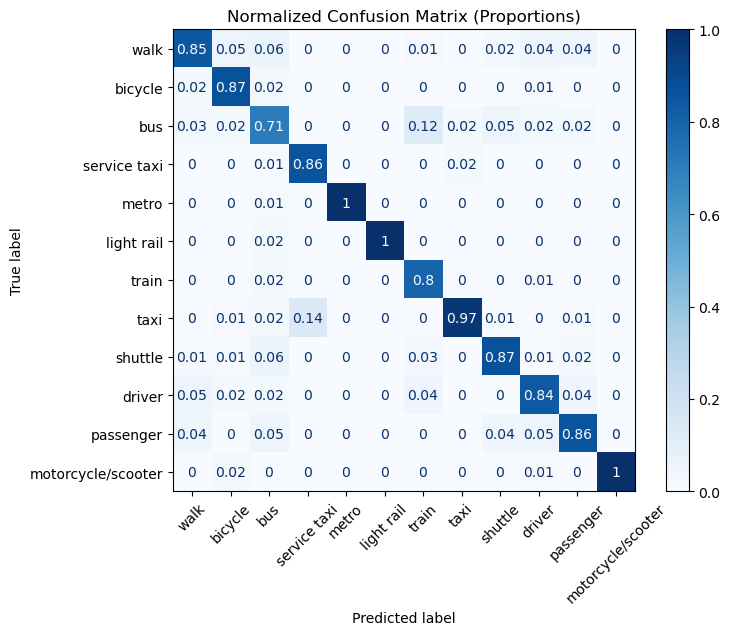

Runtime: 125.34 seconds
XGBoost model:
Model accuracy: 0.810

Classification report:
                     precision    recall  f1-score   support

              walk       0.81      0.86      0.83     21099
           bicycle       0.58      0.13      0.22      1171
               bus       0.66      0.60      0.63      5735
      service taxi       0.67      0.02      0.03       131
             metro       0.76      0.19      0.30        85
        light rail       0.42      0.09      0.14       196
             train       0.60      0.22      0.32       448
              taxi       0.47      0.05      0.09       538
           shuttle       0.76      0.54      0.63      3064
            driver       0.83      0.93      0.88     36158
         passenger       0.82      0.74      0.78     15575
motorcycle/scooter       0.88      0.10      0.18       652

          accuracy                           0.81     84852
         macro avg       0.69      0.37      0.42     84852
      weight

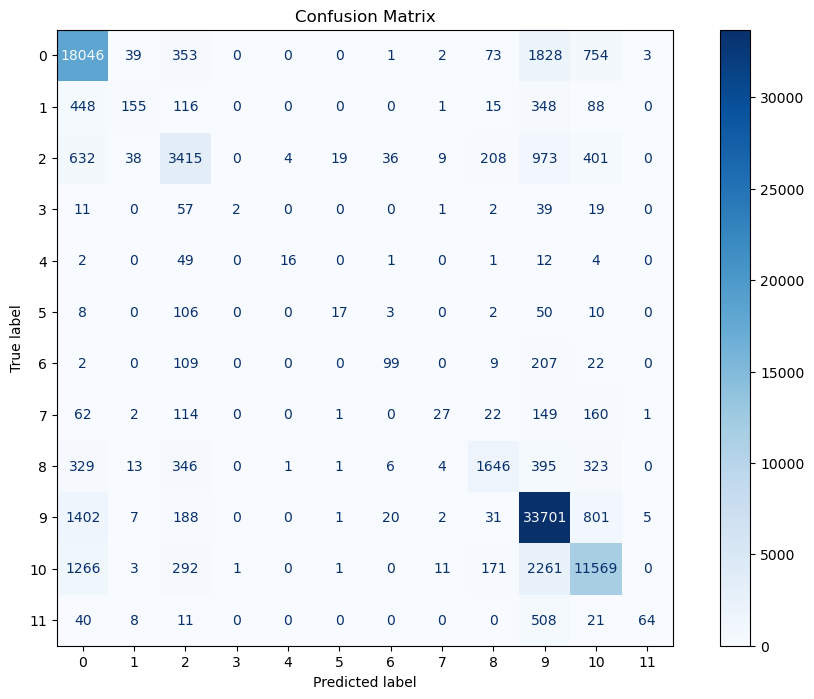

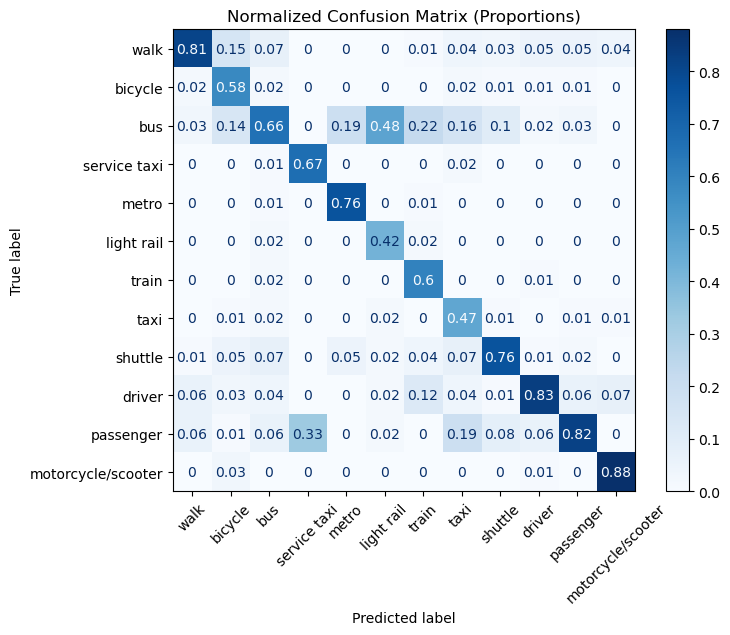

Runtime: 480.09 seconds
LightGBM model:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 339407, number of used features: 54
[LightGBM] [Info] Start training from score -1.391716
[LightGBM] [Info] Start training from score -4.283475
[LightGBM] [Info] Start training from score -2.694318
[LightGBM] [Info] Start training from score -6.475374
[LightGBM] [Info] Start training from score -6.911909
[LightGBM] [Info] Start training from score -6.069272
[LightGBM] [Info] Start training from score -5.243310
[LightGBM] [Info] Start training from score -5.060802
[LightGBM] [Info] Start training from score -3.321021
[LightGBM] [Info] Start training from score -0.853014
[LightGBM] [Info] Start training from score -1.695206
[LightGBM] [

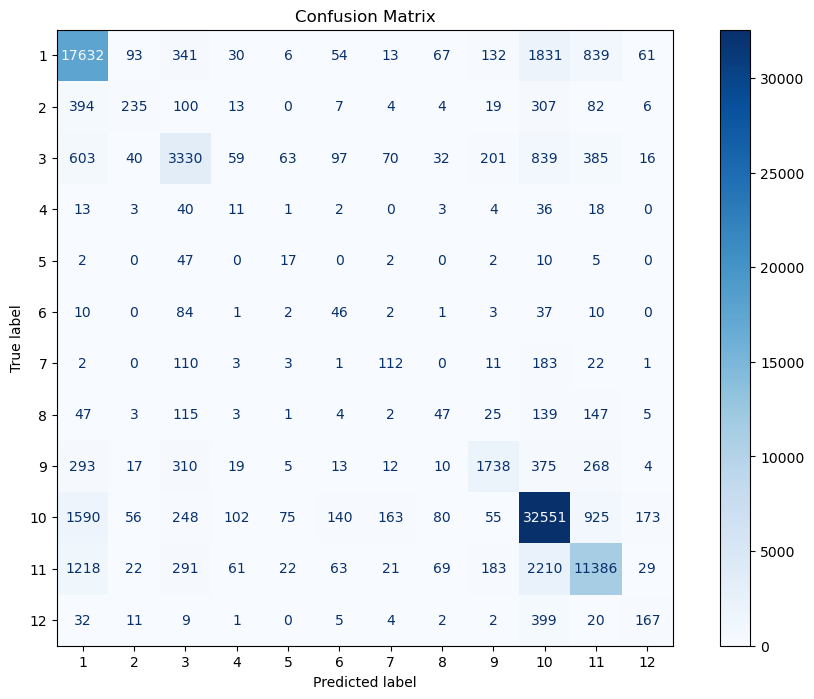

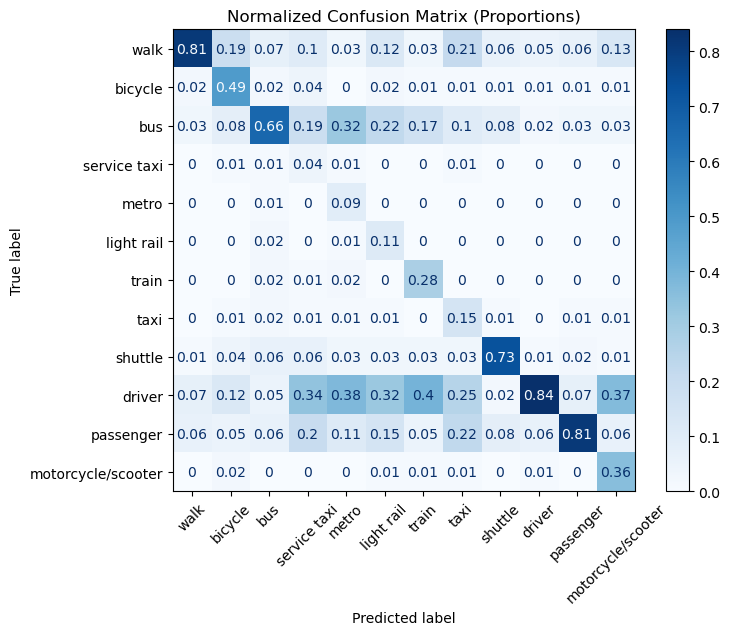

Runtime: 33.72 seconds
CatBoost model:
0:	learn: 1.9242677	total: 633ms	remaining: 2m 6s
1:	learn: 1.6812367	total: 1.07s	remaining: 1m 46s
2:	learn: 1.5197236	total: 1.52s	remaining: 1m 39s
3:	learn: 1.4036418	total: 1.96s	remaining: 1m 35s
4:	learn: 1.3105799	total: 2.39s	remaining: 1m 33s
5:	learn: 1.2339767	total: 2.86s	remaining: 1m 32s
6:	learn: 1.1714900	total: 3.32s	remaining: 1m 31s
7:	learn: 1.1163755	total: 3.79s	remaining: 1m 30s
8:	learn: 1.0692047	total: 4.26s	remaining: 1m 30s
9:	learn: 1.0307897	total: 4.73s	remaining: 1m 29s
10:	learn: 0.9963258	total: 5.2s	remaining: 1m 29s
11:	learn: 0.9670138	total: 5.66s	remaining: 1m 28s
12:	learn: 0.9410715	total: 6.15s	remaining: 1m 28s
13:	learn: 0.9180603	total: 6.85s	remaining: 1m 31s
14:	learn: 0.8976612	total: 7.52s	remaining: 1m 32s
15:	learn: 0.8796630	total: 8.2s	remaining: 1m 34s
16:	learn: 0.8635864	total: 8.85s	remaining: 1m 35s
17:	learn: 0.8480527	total: 9.38s	remaining: 1m 34s
18:	learn: 0.8341547	total: 9.93s	rema

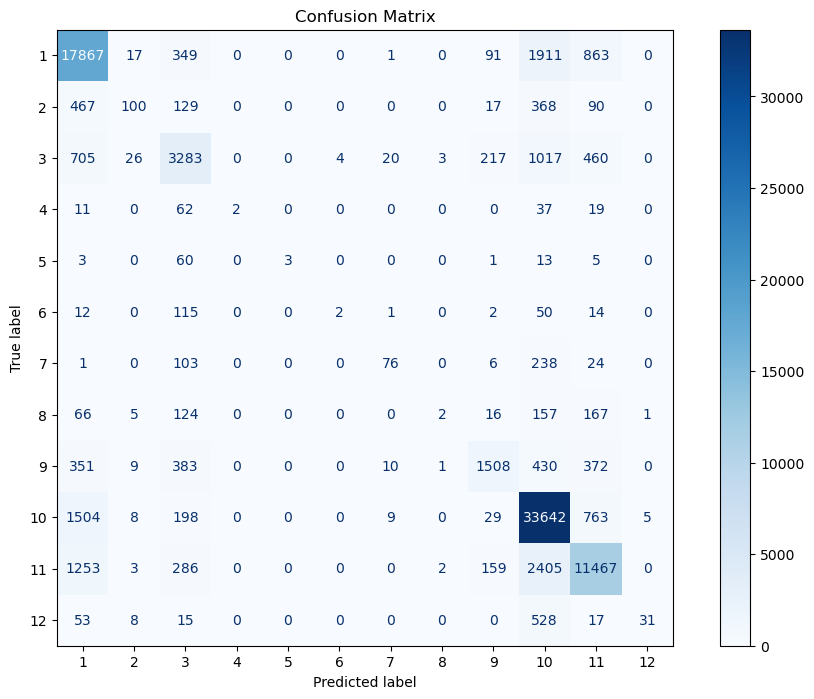

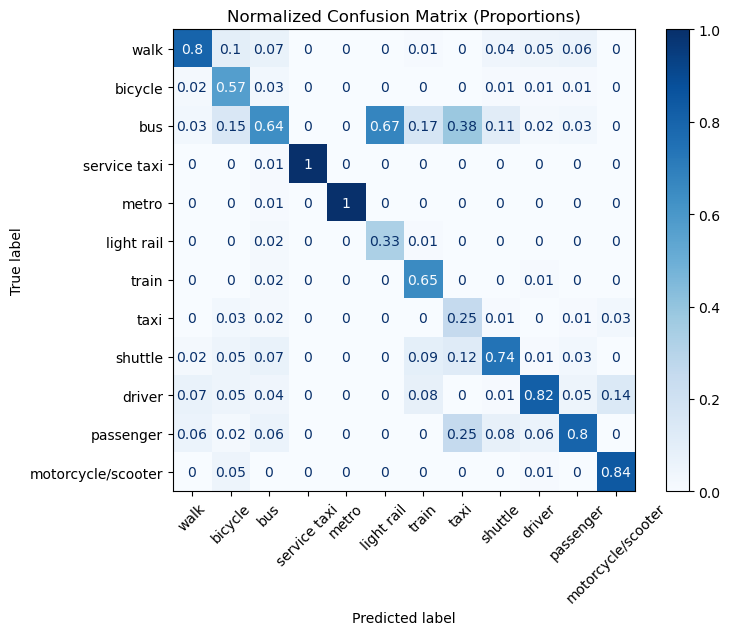

Runtime: 116.66 seconds
Logistic Regression model:
Model accuracy: 0.687

Classification report:
                     precision    recall  f1-score   support

              walk       0.61      0.66      0.63     21099
           bicycle       0.09      0.00      0.00      1171
               bus       0.56      0.29      0.38      5735
      service taxi       0.00      0.00      0.00       131
             metro       0.00      0.00      0.00        85
        light rail       0.20      0.02      0.03       196
             train       0.27      0.01      0.02       448
              taxi       0.00      0.00      0.00       538
           shuttle       0.56      0.26      0.35      3064
            driver       0.75      0.93      0.83     36158
         passenger       0.65      0.53      0.59     15575
motorcycle/scooter       0.59      0.02      0.03       652

          accuracy                           0.69     84852
         macro avg       0.36      0.23      0.24     84852


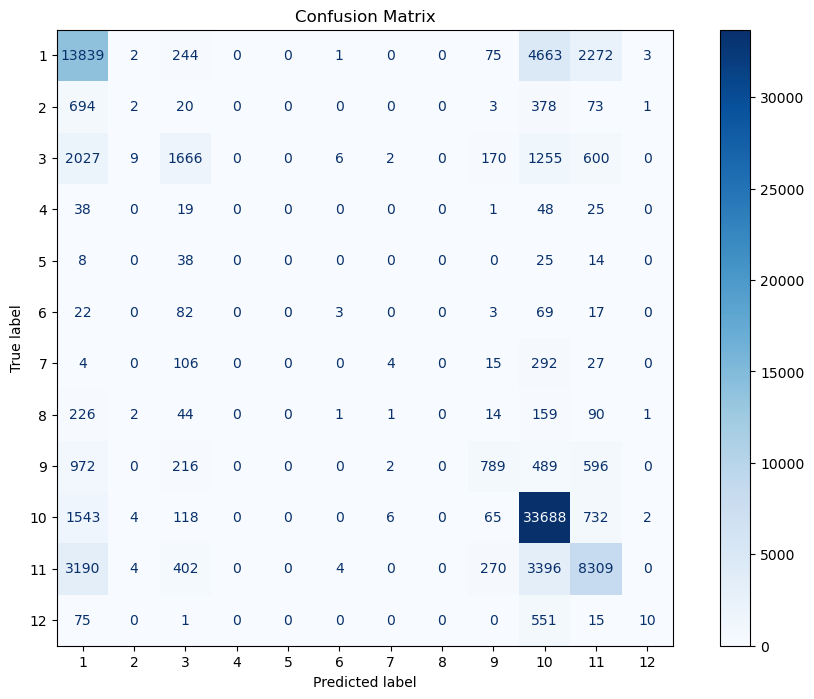

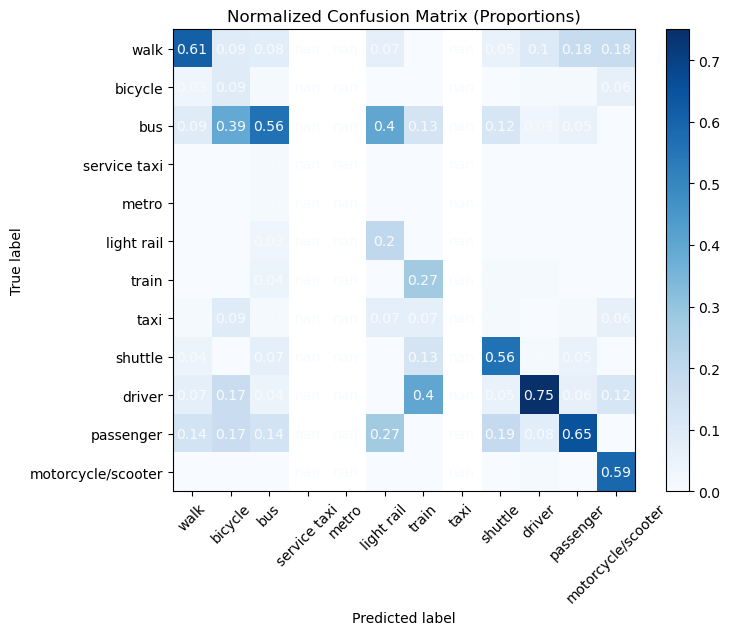

Runtime: 67.04 seconds
Neural Network model:
Epoch 1/100
2263/2263 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6420 - loss: 1.1515 - val_accuracy: 0.6941 - val_loss: 0.8847
Epoch 2/100
2263/2263 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7179 - loss: 0.8131 - val_accuracy: 0.7286 - val_loss: 0.7790
Epoch 3/100
2263/2263 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7301 - loss: 0.7669 - val_accuracy: 0.7340 - val_loss: 0.7570
Epoch 4/100
2263/2263 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7364 - loss: 0.7437 - val_accuracy: 0.7263 - val_loss: 0.7780
Epoch 5/100
2263/2263 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7392 - loss: 0.7313 - val_accuracy: 0.7301 - val_loss: 0.7572
Epoch 6/100
2263/2263 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7427 - loss: 0.7181 - val_accuracy: 0.7378 - val_loss: 0.7339
Epoch 7/100
2263/2263 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7459 - loss: 0.7069 - val_accuracy: 0.7450 - val_loss: 0.7205
Epoch 8/100
2263/2263 ━━━━━━━━━━━━━━━

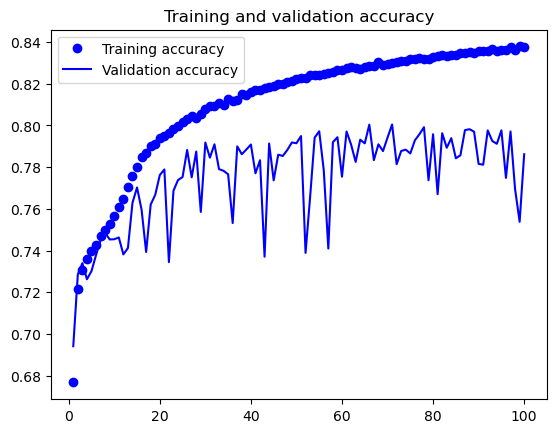

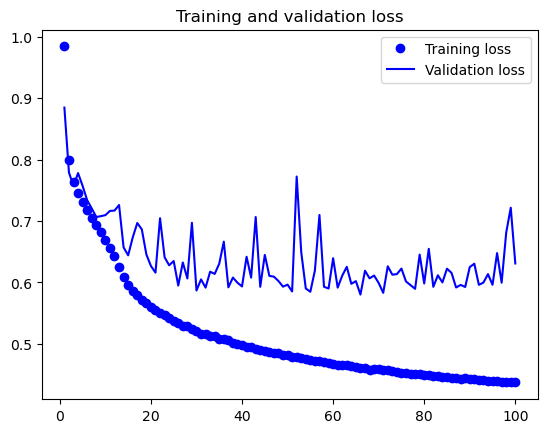

2652/2652 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7988 - loss: 0.5874
Best model evaluation: [0.5861042737960815, 0.7996982932090759]
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 2s 878us/step

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80     21099
           1       0.60      0.29      0.39      1171
           2       0.63      0.60      0.61      5735
           3       0.29      0.05      0.08       131
           4       0.44      0.19      0.26        85
           5       0.34      0.21      0.26       196
           6       0.43      0.23      0.30       448
           7       0.35      0.09      0.15       538
           8       0.67      0.58      0.63      3064
           9       0.84      0.92      0.88     36158
          10       0.80      0.76      0.78     15575
          11       0.60      0.32      0.42       652

    accuracy                           0.80     84852
   macro avg       0.57      0.

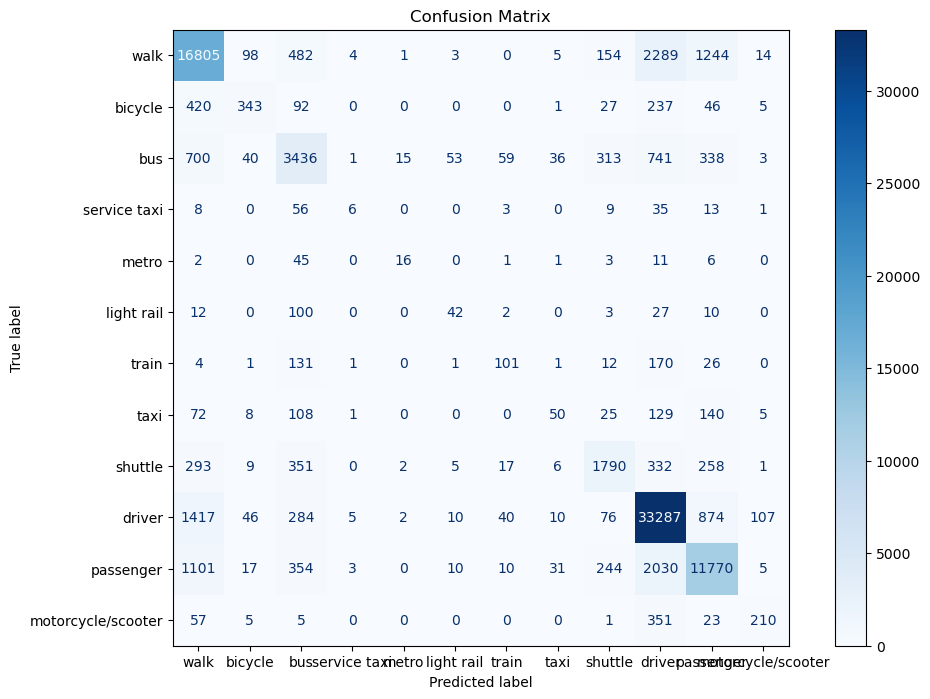

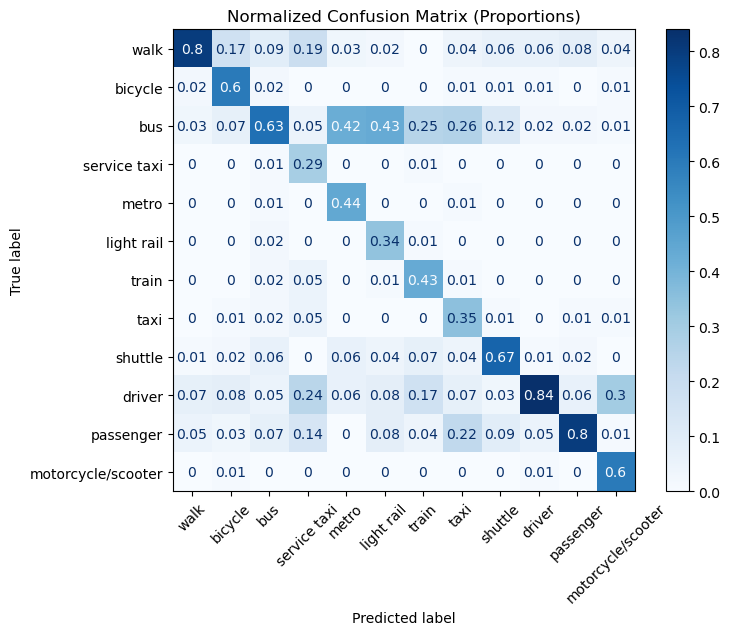

Runtime: 913.24 seconds


In [42]:
for name, model in models.items():
    print(f"{name} model:")
    
    if name == 'Neural Network':
        start_time = time.time()
        nn_iteration(nn_model, 100 ,120) # Chosen parameters for network after a lot of try and error
        end_time = time.time()
        print(f"Runtime: {end_time - start_time:.2f} seconds")
         
    else:
        start_time = time.time()
        # activate label encoding from 0 only for xgb model (must have) and no scaling only for RF (performes better)
        pl = end2end_pipeline(df, num_feats, cat_feats, model, zero_labeling = name=='XGBoost', abort_scaling = name == 'Random Forest', abort_X_oh = name == 'CatBoost') 
        end_time = time.time()
        print(f"Runtime: {end_time - start_time:.2f} seconds")
    print("=============================================================")



#### 

In [44]:
# Manual result insertion to aviod code complexities

summary = {
    'Accuracy': [0.838, 0.810, 0.793, 0.801, 0.687, 0.802], 
    'Presicion': [0.840 , 0.802, 0.789, 0.791, 0.656, 0.795], 
    'Recall': [0.838 , 0.810, 0.793, 0.800, 0.687, 0.803], 
    'F1': [0.826, 0.797 , 0.783, 0.788, 0.658, 0.796],  
    'Runtime (s)': [54.97, 507.47, 35.21, 107.18, 51.40 ,728.20],
}

s_index = list(models.keys())
summary = pd.DataFrame(summary, index = s_index)
summary

,Accuracy,Presicion,Recall,F1,Runtime (s)
Random Forest,0.838,0.840,0.838,0.826,54.97
XGBoost,0.810,0.802,0.810,0.797,507.47
LightGBM,0.793,0.789,0.793,0.783,35.21
CatBoost,0.801,0.791,0.800,0.788,107.18
Logistic Regression,0.687,0.656,0.687,0.658,51.40
Neural Network,0.802,0.795,0.803,0.796,728.20


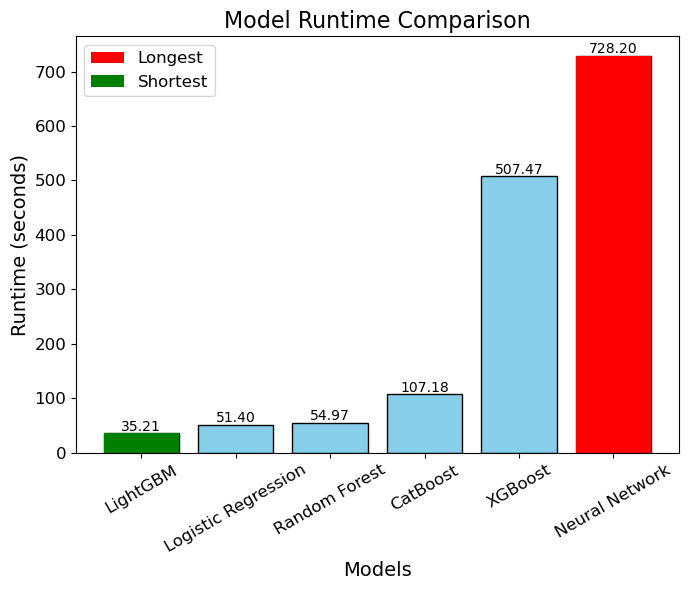

In [45]:
# Visualize performances for convinient comparison
summary_df = summary.reset_index().sort_values('Runtime (s)').rename(columns = {'index':'models'})

plt.figure(figsize=(7,6))
plt.bar(summary_df['models'], summary_df['Runtime (s)'], color='skyblue', edgecolor='black')
# Highlight the longest and shortest runtime
longest = max(summary_df['Runtime (s)'])
shortest = min(summary_df['Runtime (s)'])
plt.bar(list(summary_df.models)[-1], longest, color='red', label='Longest')
plt.bar(list(summary_df.models)[0], shortest, color='green', label='Shortest')

### Code by LLM ### 
for i, r in enumerate(summary_df['Runtime (s)']):
    plt.text(i, r + 5, f'{r:.2f}', ha='center', fontsize=10)
###################

plt.title('Model Runtime Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Runtime (seconds)', fontsize=14)
plt.xticks(fontsize=12, rotation = 30)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

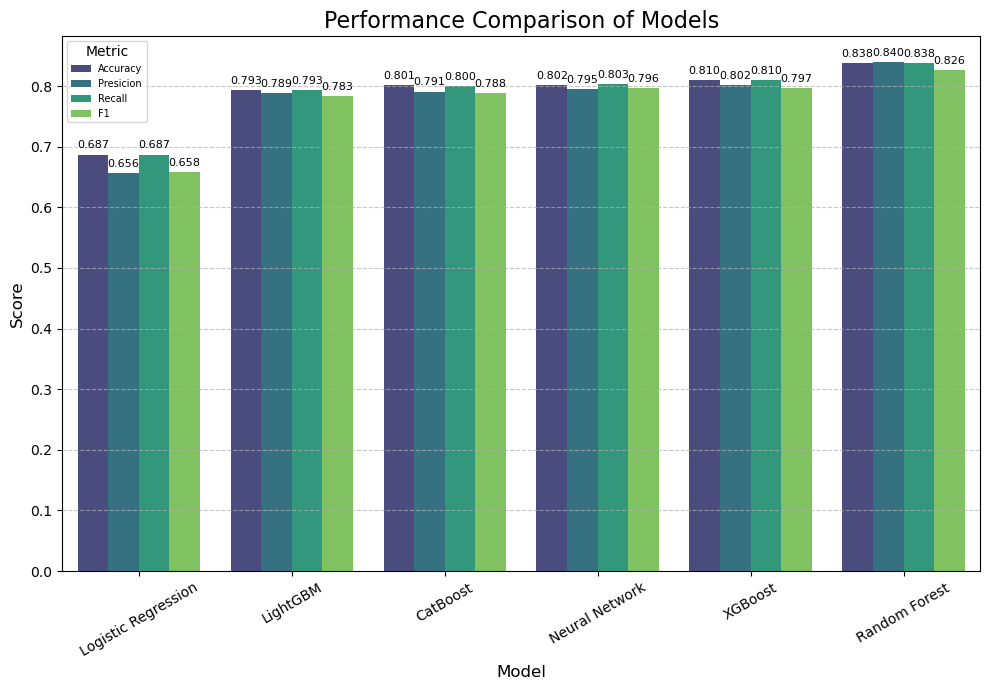

In [46]:
# Rumtime comparison
s_index = list(models.keys())
re_summary = summary.reset_index().rename(columns = {'index':'Model'}).sort_values('Accuracy')
df_melted = re_summary.iloc[:,:-1].melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 7))
ax = sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette='viridis')

### Code by LLM ### 
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=8, color='black', padding=3)
###################

plt.title('Performance Comparison of Models', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=30, fontsize=10)
plt.legend(title='Metric', fontsize=7, loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### PCA & LDA : Finding optimal dimensions size for our data by explained variance ratio

##### Define preprocessor to scale and impute the data before dimensionals transformations

In [49]:
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler())])
categorical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first', sparse_output = False))  ])

preprocessor = ColumnTransformer([('num', numerical_pipeline, num_feats), ('cat', categorical_pipeline, cat_feats[1:])])

df = cdf
X, y = preprocess_data(df)

##### PCA:

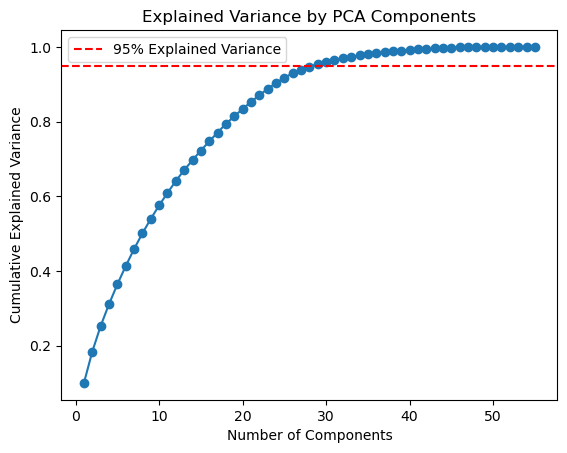

In [51]:
X_scaled = preprocessor.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)
cumulative_variance = pca.explained_variance_ratio_.cumsum() # Cummulative variance

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

In [52]:
threshold = 0.01 # components with explained variance < 1%
important_components = np.sum(pca.explained_variance_ratio_ > threshold)
print(f'Number of components explaining > {threshold * 100}% variance is: {important_components}')

Number of components explaining > 1.0% variance is: 26


##### LDA:

In [54]:
df = cdf
X, y = preprocess_data(df)

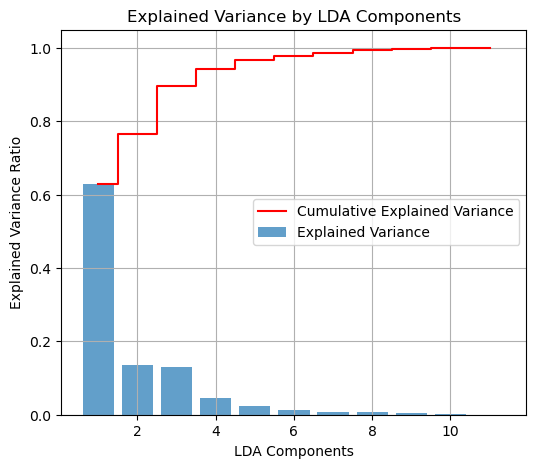

In [55]:
lda = LDA(n_components=len(y.unique())-1)
X_scaled = preprocessor.fit_transform(X)
lda.fit(X_scaled, y)

### Code by LLM ###
explained_variance_ratio = lda.explained_variance_ratio_
plt.figure(figsize=(6, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Explained Variance')
plt.step(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), where='mid', color='red', label='Cumulative Explained Variance')
###################

plt.xlabel('LDA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by LDA Components')
plt.legend(loc='right')
plt.grid()
plt.show()

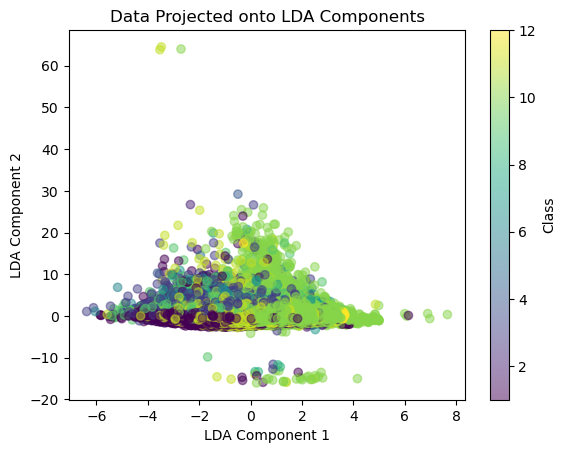

In [56]:
lda = LDA(n_components = 4)
lda.fit(X_scaled, y)
lda_transformed = lda.transform(X_scaled)  # Transform data to LDA space

plt.scatter(lda_transformed[:, 0], lda_transformed[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('Data Projected onto LDA Components')
plt.colorbar(label='Class')
plt.show()

##### Generating dimensionally-redused (PCA,LDA) splitted data for quick access when managing unsupervised learning part

In [58]:
X, y = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

op_pca2 = PCA(n_components = 26) # Optimal components number by our previous definition

X_train_temp = preprocessor.fit_transform(X_train)
X_test_temp = preprocessor.transform(X_test)

X_train_pca = op_pca2.fit_transform(X_train_temp)
X_test_pca = op_pca2.transform(X_test_temp)

In [59]:
lda2 = LDA(n_components=4) 

X_train_temp = preprocessor.fit_transform(X_train)
X_test_temp = preprocessor.transform(X_test)

X_train_lda = lda2.fit_transform(X_train_temp, y_train)
X_test_lda = lda2.transform(X_test_temp)

---